# 🌿 Predicting Optimal Fertilizer — EDA (with Insights Cards)

Green-themed EDA with an *Insights Summary Plot* (text + icons on a green card) after each graph group.

## 0. Helper — Insights Summary Card

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
import warnings
warnings.filterwarnings('ignore')

def insight_card(title, bullets, footer=None, height=3.2, width=12, face='#E1F8DC'):
    fig = plt.figure(figsize=(width, height), facecolor=face)
    ax = fig.add_axes([0,0,1,1]); ax.axis('off')
    ax.text(0.02, 0.82, f"{title}", fontsize=18, fontweight='bold', color='#044425')
    y = 0.62
    for b in bullets:
        ax.text(0.03, y, f"🌿  {b}", fontsize=13, color='#044425'); y -= 0.16
    if footer:
        ax.text(0.02, 0.06, footer, fontsize=11, color='#044425')
    plt.show()

pd.set_option("display.max_columns", 50)

raw_palette = ["#70de88", "#FFA51F", "#6F25EFFF", "#006917", "#636d65", "#5178d9", "#22bc86", "#ffffff"]
def _fix_hex(c):
    return "#" + c[1:7] if isinstance(c, str) and c.startswith('#') and len(c)==9 else c
palette = [_fix_hex(c) for c in raw_palette]
palette = [c if (isinstance(c,str) and c.startswith('#') and len(c)==7) else '#00774E' for c in palette]

sns.set_theme(style="whitegrid", palette=palette)

plt.rcParams.update({
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titlesize": 25,
    "axes.titleweight": 'bold',
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    "axes.labelsize": 20,
    "legend.fontsize": 15,
    "legend.title_fontsize": 15,
    'figure.facecolor': '#E1F8DC',
    'axes.facecolor':   '#F2FFF2',
    'savefig.facecolor':'#E1F8DC'
})

px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = palette
PAPER_BGCOLOR = '#E1F8DC'
PLOT_BGCOLOR  = '#CAF1DE'

## 1. Imports & Config

In [2]:
import joblib

from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

PROJECT_HOME = os.getcwd()
# Paths

TRAIN_PATH = PROJECT_HOME+"/data/train_kaggle.csv"
TEST_PATH  = PROJECT_HOME+"/data/test_kaggle.csv"
ORIGINAL_PATH = PROJECT_HOME+"/data/train_ieee.csv"

RANDOM_STATE = 42
N_SPLITS = 5


## 2. Load Data

In [3]:
train = pd.read_csv(TRAIN_PATH, low_memory=False)
test  = pd.read_csv(TEST_PATH, low_memory=False)
original = pd.read_csv(ORIGINAL_PATH, low_memory=False)

train = train.drop(columns=['id'])
df = pd.concat([train, original], ignore_index=True)

print("Train shape:", df.shape, "| Test shape:", test.shape)
display(df.head(3))
display(test.head(3))

Train shape: (850000, 9) | Test shape: (250000, 9)


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4


## 3. Insights

In [4]:
print('Rows:', df.shape[0], '| Cols:', df.shape[1])
df.info()

Rows: 850000 | Cols: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850000 entries, 0 to 849999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      850000 non-null  int64 
 1   Humidity         850000 non-null  int64 
 2   Moisture         850000 non-null  int64 
 3   Soil Type        850000 non-null  object
 4   Crop Type        850000 non-null  object
 5   Nitrogen         850000 non-null  int64 
 6   Potassium        850000 non-null  int64 
 7   Phosphorous      850000 non-null  int64 
 8   Fertilizer Name  850000 non-null  object
dtypes: int64(6), object(3)
memory usage: 58.4+ MB


## 4. Duplicate Rows

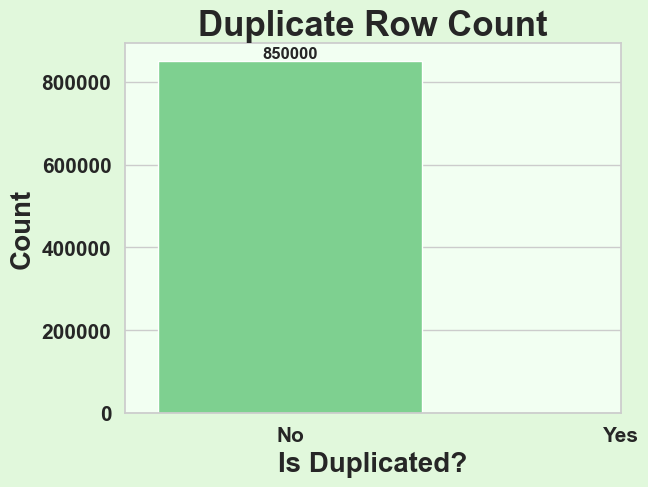

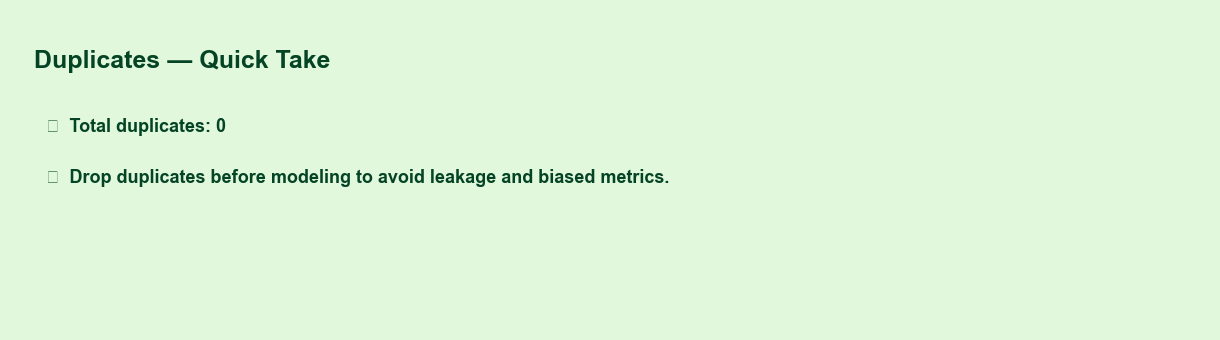

In [5]:
dup_count = df.duplicated().sum()
sns.countplot(x=df.duplicated())
plt.title('Duplicate Row Count'); plt.xlabel('Is Duplicated?'); plt.ylabel('Count')
plt.xticks([0,1], ['No','Yes'])
for i, v in enumerate(df.duplicated().value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)
plt.show()
insight_card("Duplicates — Quick Take", [f"Total duplicates: {dup_count}", "Drop duplicates before modeling to avoid leakage and biased metrics."])

## 5. Missing Values

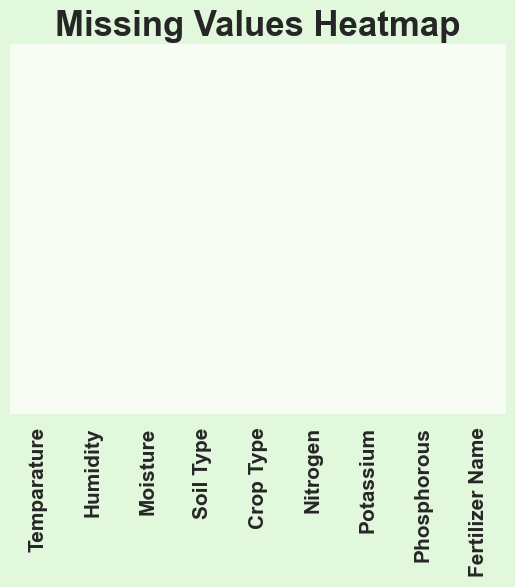

Series([], dtype: int64)

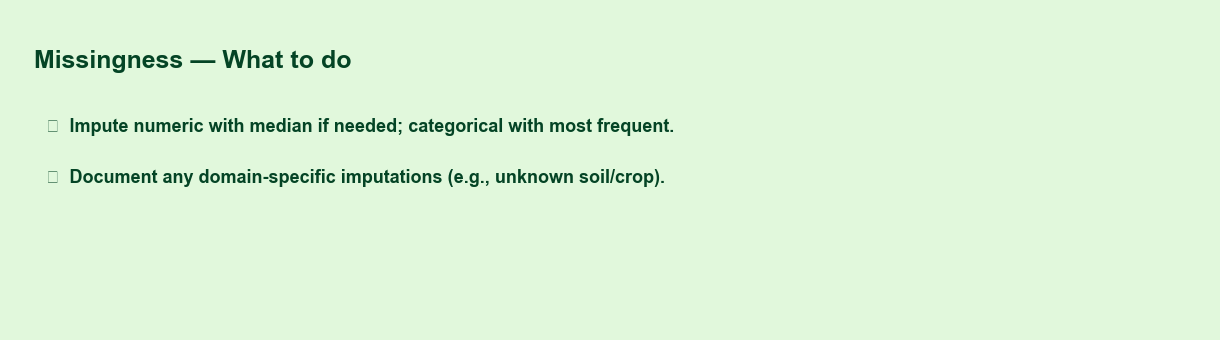

In [6]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='Greens')
plt.title('Missing Values Heatmap'); plt.show()
nulls = df.isnull().sum().sort_values(ascending=False)
display(nulls[nulls>0])
insight_card("Missingness — What to do", ["Impute numeric with median if needed; categorical with most frequent.", "Document any domain-specific imputations (e.g., unknown soil/crop)."])


## 6. Understanding Variables

In [7]:
display(df.describe(include='all'))
for c in df.columns:
    print(c, '→ unique =', df[c].nunique(dropna=False))

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
count,850000.000000,850000.000000,850000.000000,850000,850000,850000.000000,850000.000000,850000.000000,850000
unique,NaN,NaN,NaN,5,11,NaN,NaN,NaN,7
top,NaN,NaN,NaN,Sandy,Paddy,NaN,NaN,NaN,14-35-14
freq,NaN,NaN,NaN,176774,94857,NaN,NaN,NaN,128928
mean,31.503534,61.032665,45.162887,NaN,NaN,23.081215,9.477581,21.066198,NaN
std,4.024909,6.648149,11.799929,NaN,NaN,11.219842,5.765965,12.352064,NaN
min,25.000000,50.000000,25.000000,NaN,NaN,4.000000,0.000000,0.000000,NaN
25%,28.000000,55.000000,35.000000,NaN,NaN,13.000000,4.000000,10.000000,NaN
50%,32.000000,61.000000,45.000000,NaN,NaN,23.000000,9.000000,21.000000,NaN
75%,35.000000,67.000000,55.000000,NaN,NaN,33.000000,14.000000,32.000000,NaN


Temparature → unique = 14
Humidity → unique = 23
Moisture → unique = 41
Soil Type → unique = 5
Crop Type → unique = 11
Nitrogen → unique = 39
Potassium → unique = 20
Phosphorous → unique = 43
Fertilizer Name → unique = 7


## 7. Light Wrangling

In [8]:
wdf = df.copy()
num_cols = ['Temparature','Humidity','Moisture','Nitrogen','Potassium','Phosphorous']
cat_cols = ['Soil Type','Crop Type','Fertilizer Name']
for c in num_cols:
    wdf[c] = pd.to_numeric(wdf[c], errors='coerce')
for c in cat_cols:
    wdf[c] = wdf[c].astype('category')
wdf['NPK_total'] = wdf[['Nitrogen','Phosphorous','Potassium']].sum(axis=1).replace(0, np.nan)
wdf['N_pct'] = np.where(wdf['NPK_total']>0, wdf['Nitrogen']/wdf['NPK_total'], np.nan)
wdf['P_pct'] = np.where(wdf['NPK_total']>0, wdf['Phosphorous']/wdf['NPK_total'], np.nan)
wdf['K_pct'] = np.where(wdf['NPK_total']>0, wdf['Potassium']/wdf['NPK_total'], np.nan)
wdf['Moisture_band'] = pd.cut(wdf['Moisture'], bins=[-np.inf,30,50,70,np.inf], labels=['Low','Moderate','High','Very High'])
wdf.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,NPK_total,N_pct,P_pct,K_pct,Moisture_band
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,45,0.800000,0.111111,0.088889,Moderate
1,27,69,65,Sandy,Millets,30,6,18,28-28,54,0.555556,0.333333,0.111111,High
2,29,63,32,Sandy,Millets,24,12,16,17-17-17,52,0.461538,0.307692,0.230769,Moderate
3,35,62,54,Sandy,Barley,39,12,4,10-26-26,55,0.709091,0.072727,0.218182,High
4,35,58,43,Red,Paddy,37,2,16,DAP,55,0.672727,0.290909,0.036364,Moderate


## 8. Univariate — Numeric Distributions

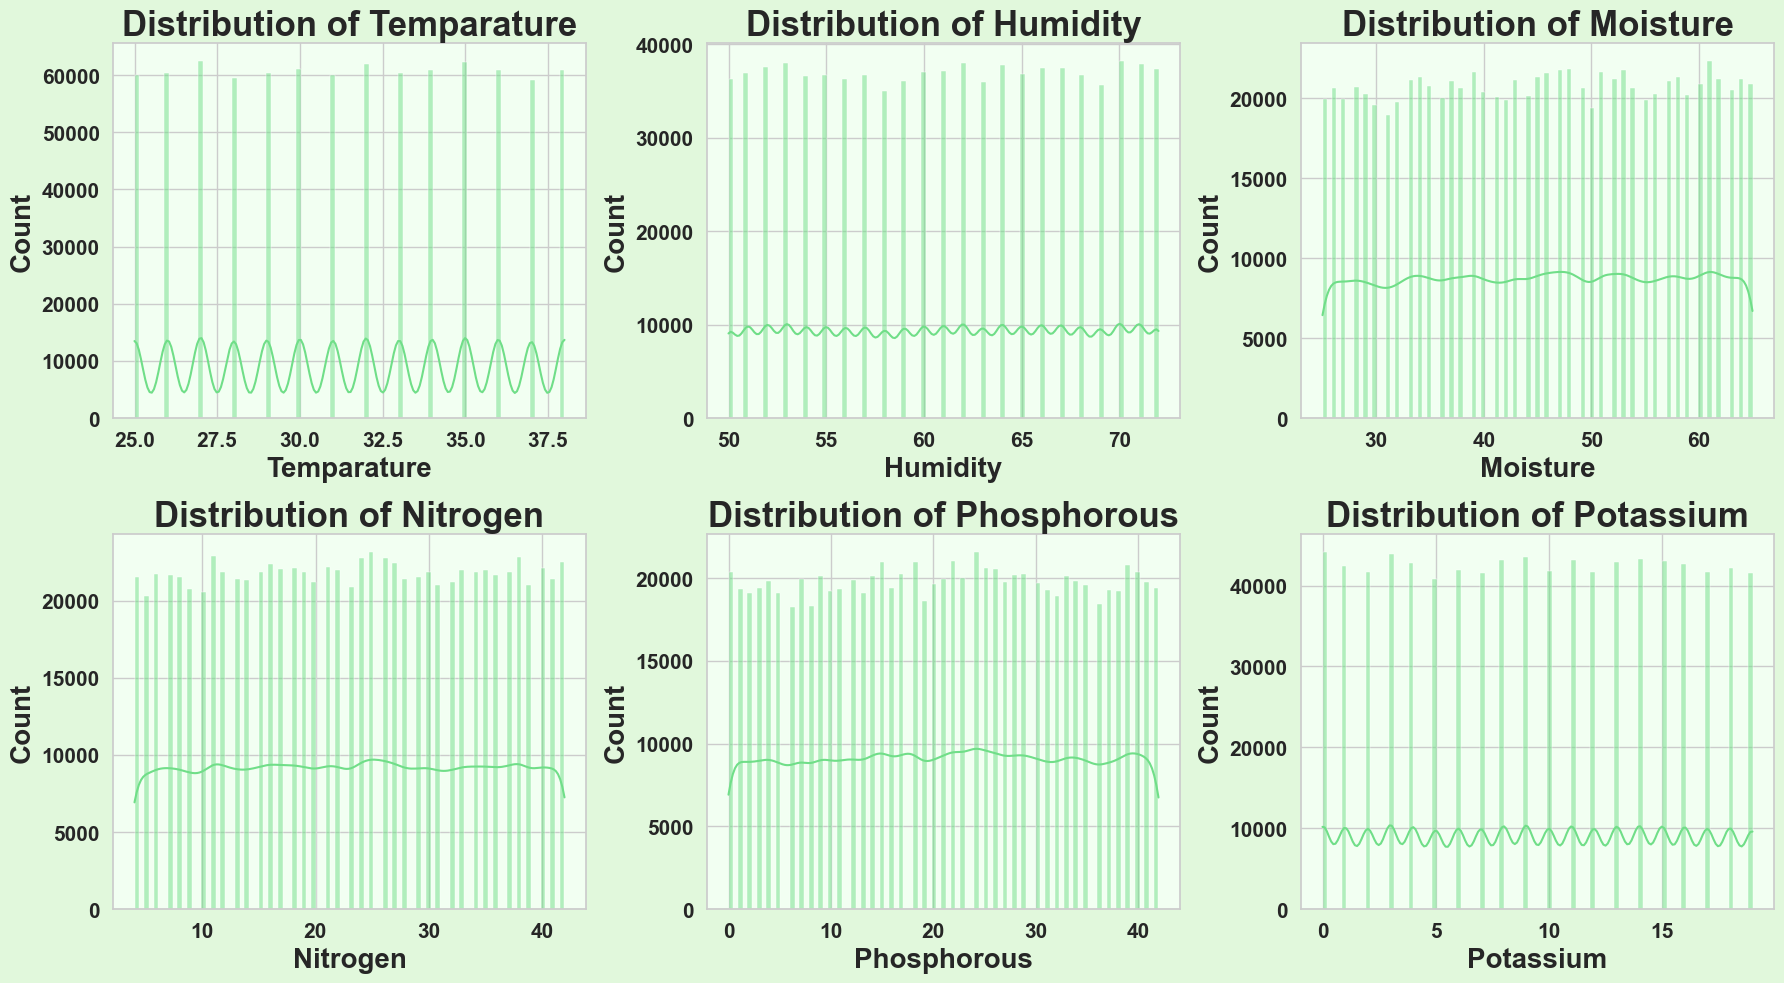

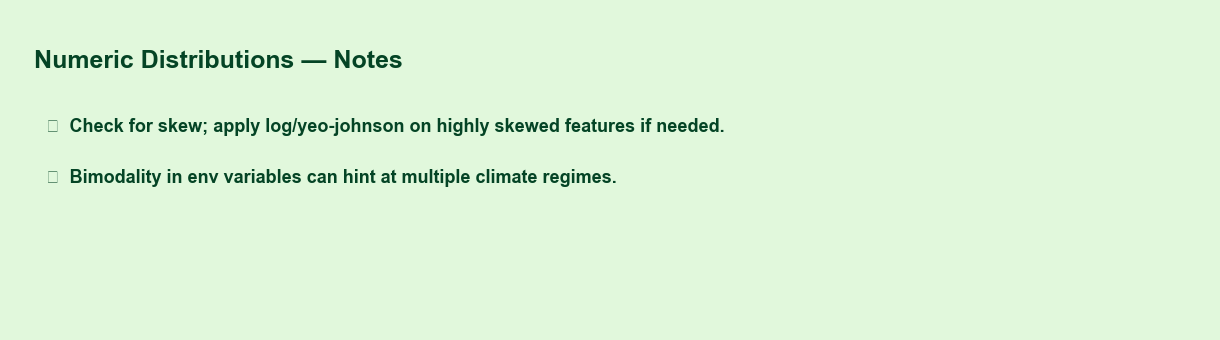

In [9]:
fig, axes = plt.subplots(2,3, figsize=(18,10)); axes = axes.ravel()
for ax, col in enumerate(['Temparature','Humidity','Moisture','Nitrogen','Phosphorous','Potassium']):
    sns.histplot(wdf[col], kde=True, ax=axes[ax]); axes[ax].set_title(f'Distribution of {col}')
plt.tight_layout(); plt.show()
insight_card("Numeric Distributions — Notes", ["Check for skew; apply log/yeo-johnson on highly skewed features if needed.", "Bimodality in env variables can hint at multiple climate regimes."])


## 9. Univariate — Categorical Distributions

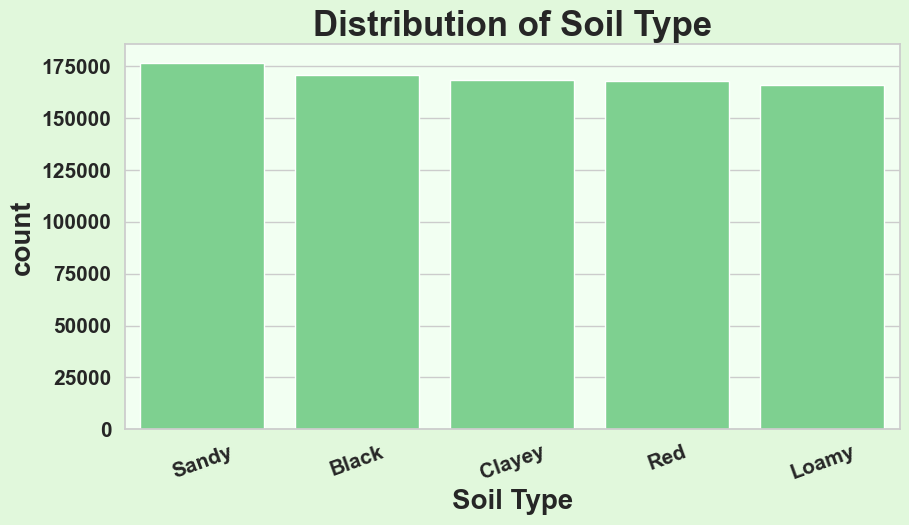

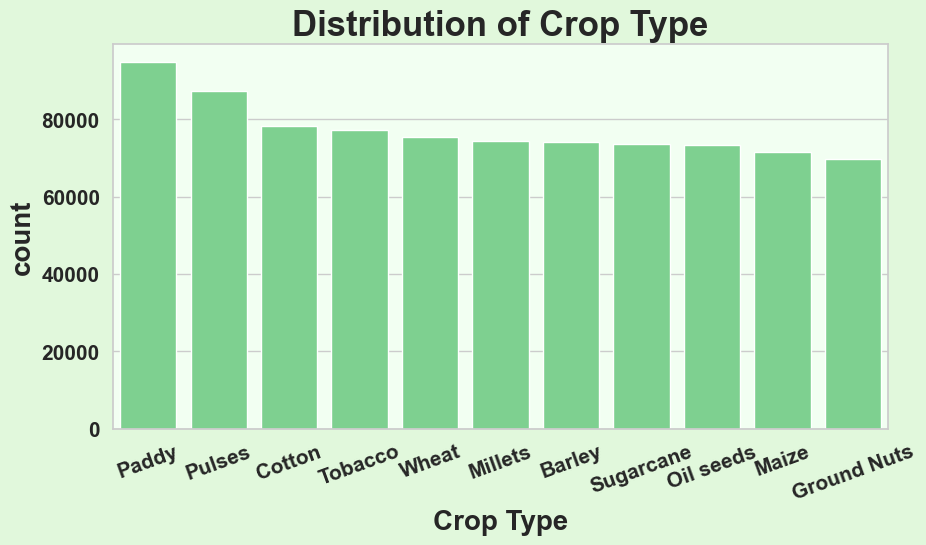

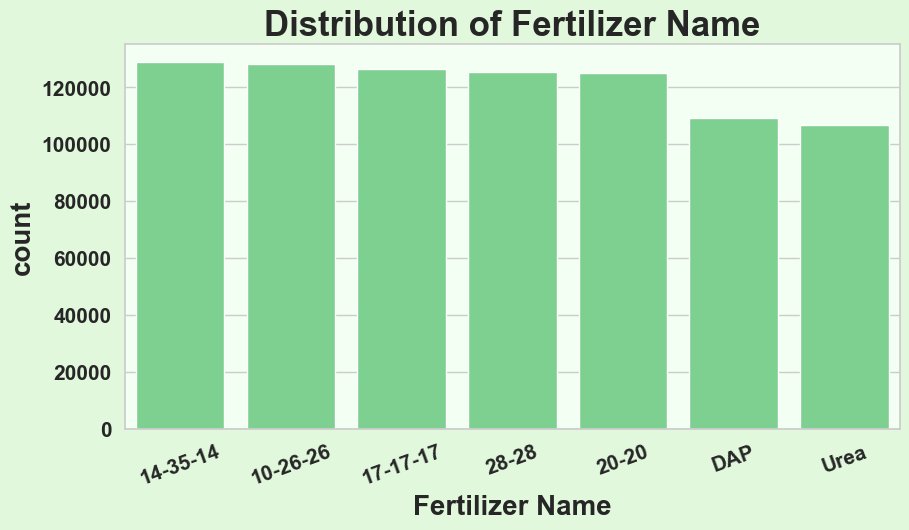

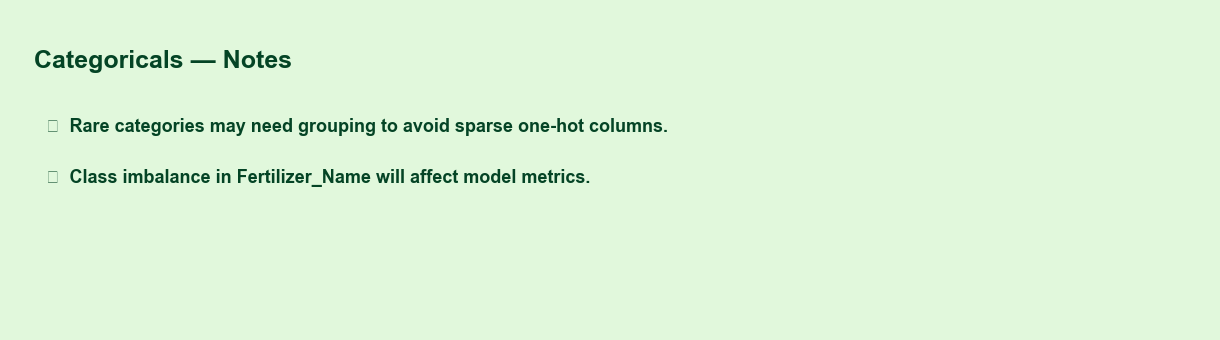

In [10]:
for col in ['Soil Type','Crop Type','Fertilizer Name']:
    order = wdf[col].value_counts().index
    plt.figure(figsize=(10,5)); sns.countplot(data=wdf, x=col, order=order)
    plt.title(f'Distribution of {col}'); plt.xticks(rotation=20); plt.show()
insight_card("Categoricals — Notes", ["Rare categories may need grouping to avoid sparse one-hot columns.", "Class imbalance in Fertilizer_Name will affect model metrics."])


## 10. Bivariate — Fertilizer vs Soil/Crop

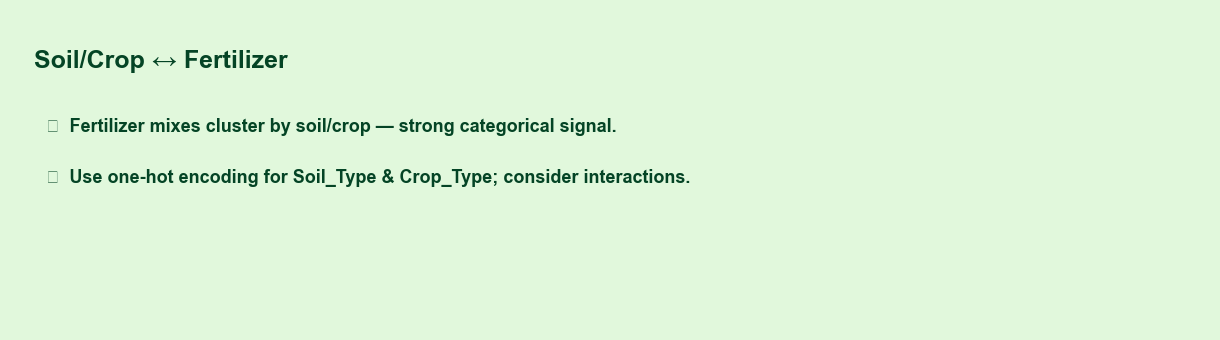

In [11]:
soil_fert = (wdf.groupby(['Soil Type','Fertilizer Name']).size().reset_index(name='count'))
fig = px.bar(soil_fert, x='Soil Type', y='count', color='Fertilizer Name', title='Fertilizer Distribution across Soil Types')
fig.update_layout(paper_bgcolor=PAPER_BGCOLOR, plot_bgcolor=PLOT_BGCOLOR); fig.show()
crop_fert = (wdf.groupby(['Crop Type','Fertilizer Name']).size().reset_index(name='count'))
fig = px.bar(crop_fert, x='Crop Type', y='count', color='Fertilizer Name', title='Fertilizer Distribution across Crop Types')
fig.update_layout(paper_bgcolor=PAPER_BGCOLOR, plot_bgcolor=PLOT_BGCOLOR); fig.show()
insight_card("Soil/Crop ↔ Fertilizer", ["Fertilizer mixes cluster by soil/crop — strong categorical signal.", "Use one-hot encoding for Soil_Type & Crop_Type; consider interactions."])


## 11. Bivariate — Boxplots by Fertilizer

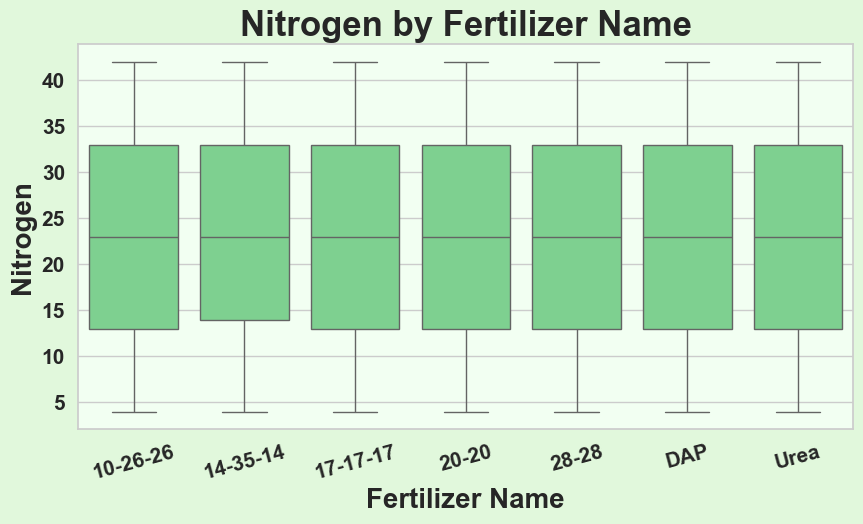

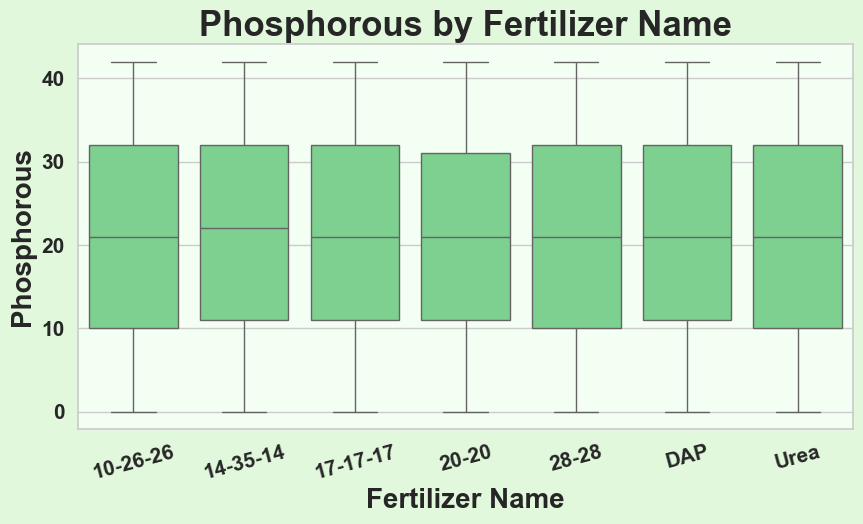

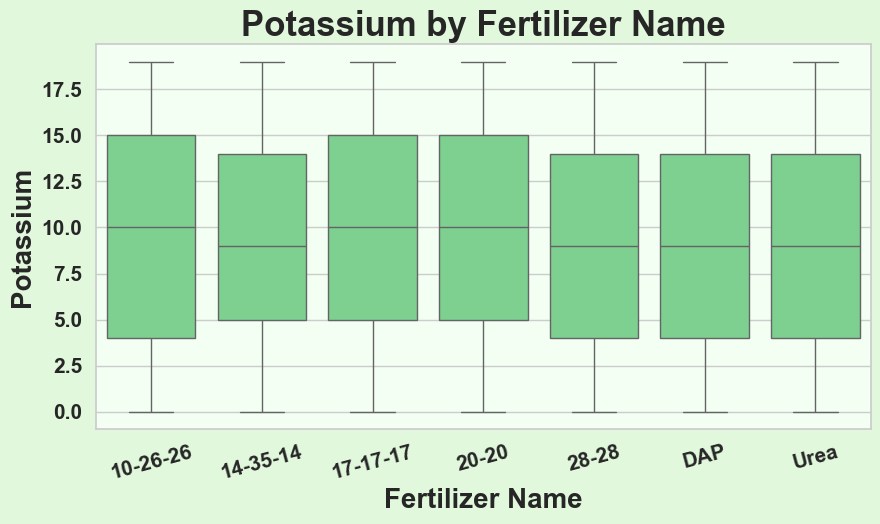

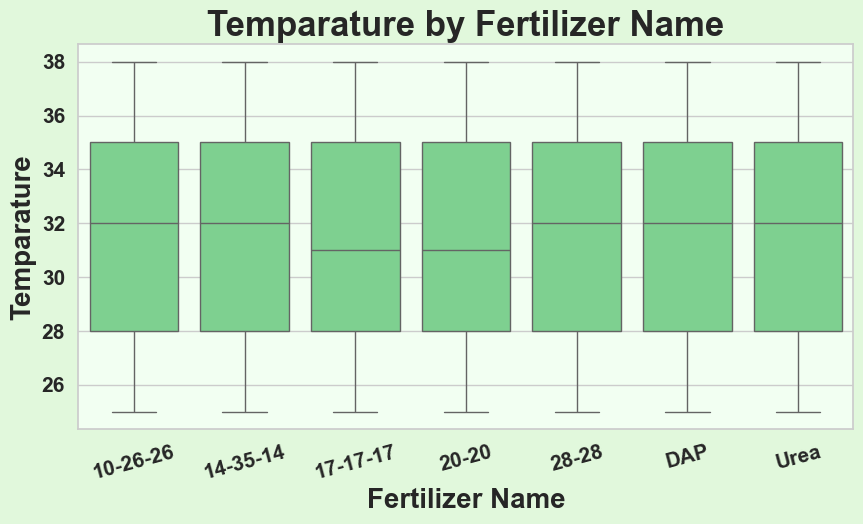

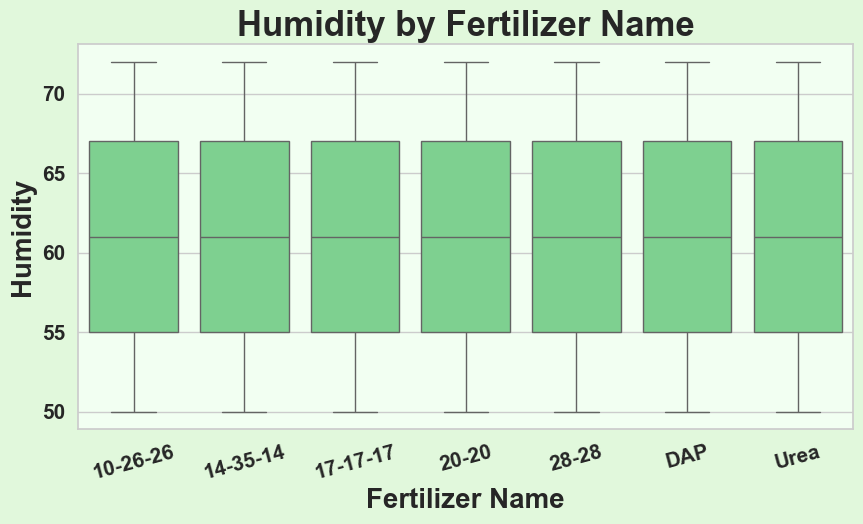

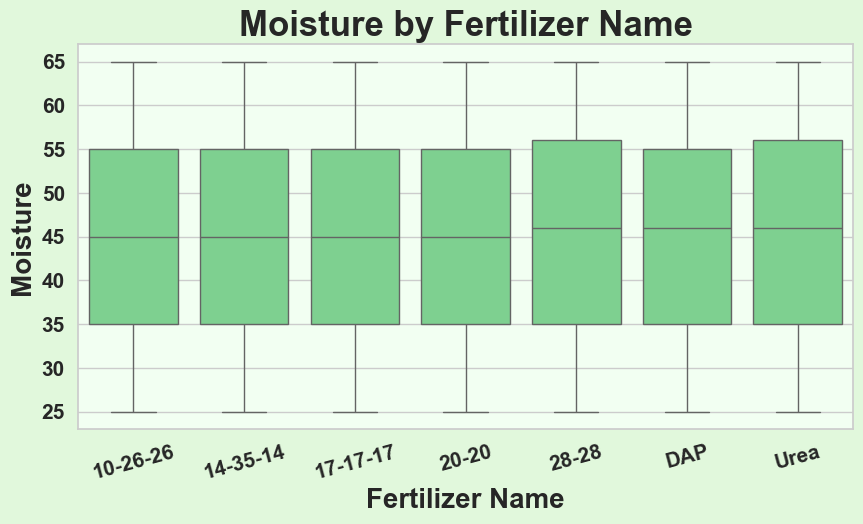

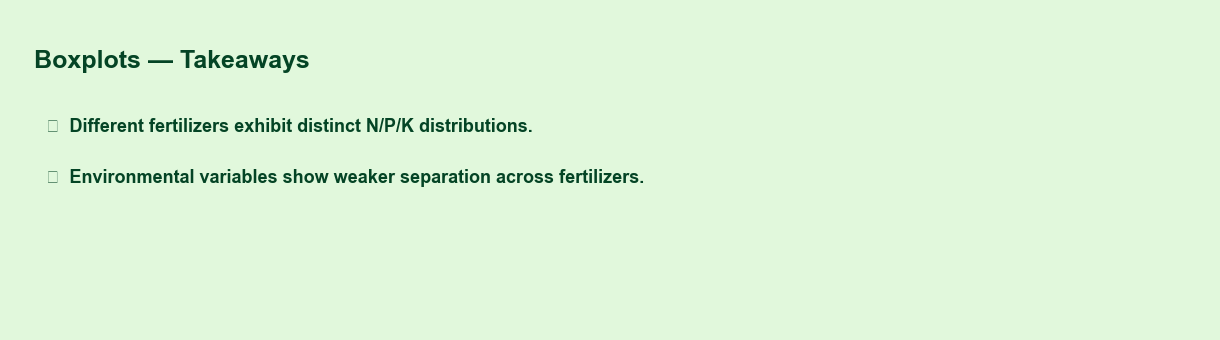

In [12]:
for col in ['Nitrogen','Phosphorous','Potassium']:
    plt.figure(figsize=(10,5)); sns.boxplot(data=wdf, x='Fertilizer Name', y=col)
    plt.title(f'{col} by Fertilizer Name'); plt.xticks(rotation=15); plt.show()
for col in ['Temparature','Humidity','Moisture']:
    plt.figure(figsize=(10,5)); sns.boxplot(data=wdf, x='Fertilizer Name', y=col)
    plt.title(f'{col} by Fertilizer Name'); plt.xticks(rotation=15); plt.show()
insight_card("Boxplots — Takeaways", ["Different fertilizers exhibit distinct N/P/K distributions.", "Environmental variables show weaker separation across fertilizers."])


## 12. Correlation Heatmap

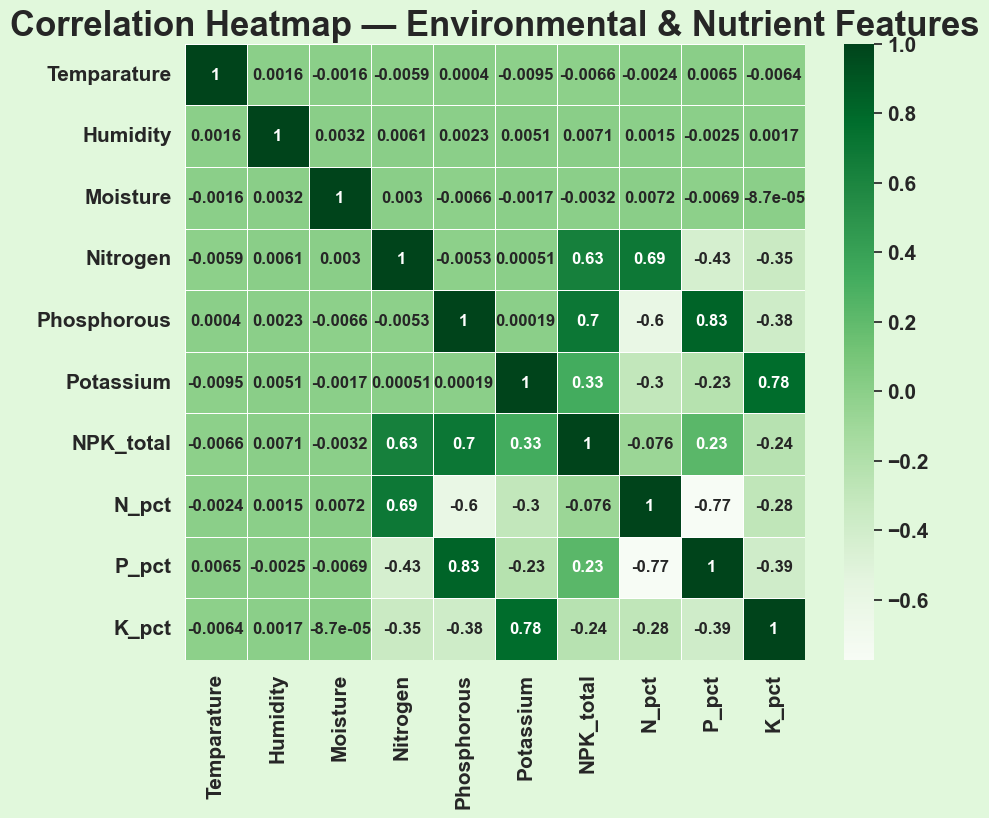

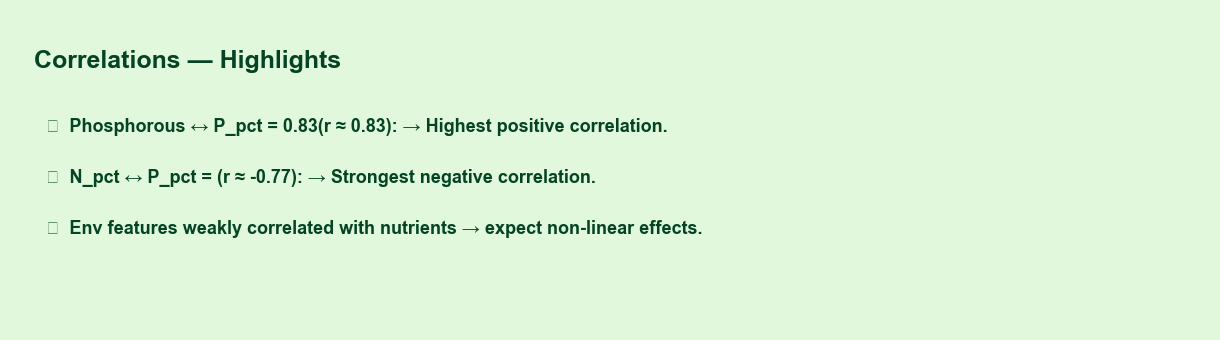

In [13]:
corr_cols = ['Temparature','Humidity','Moisture','Nitrogen','Phosphorous','Potassium','NPK_total','N_pct','P_pct','K_pct']
corr = wdf[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='Greens', linewidths=0.5)
plt.title('Correlation Heatmap — Environmental & Nutrient Features')
plt.show()
insight_card("Correlations — Highlights", ["Phosphorous ↔ P_pct = 0.83(r ≈ 0.83): → Highest positive correlation.", "N_pct ↔ P_pct = (r ≈ -0.77): → Strongest negative correlation.", "Env features weakly correlated with nutrients → expect non-linear effects."])


## 13. Pairwise Relationships

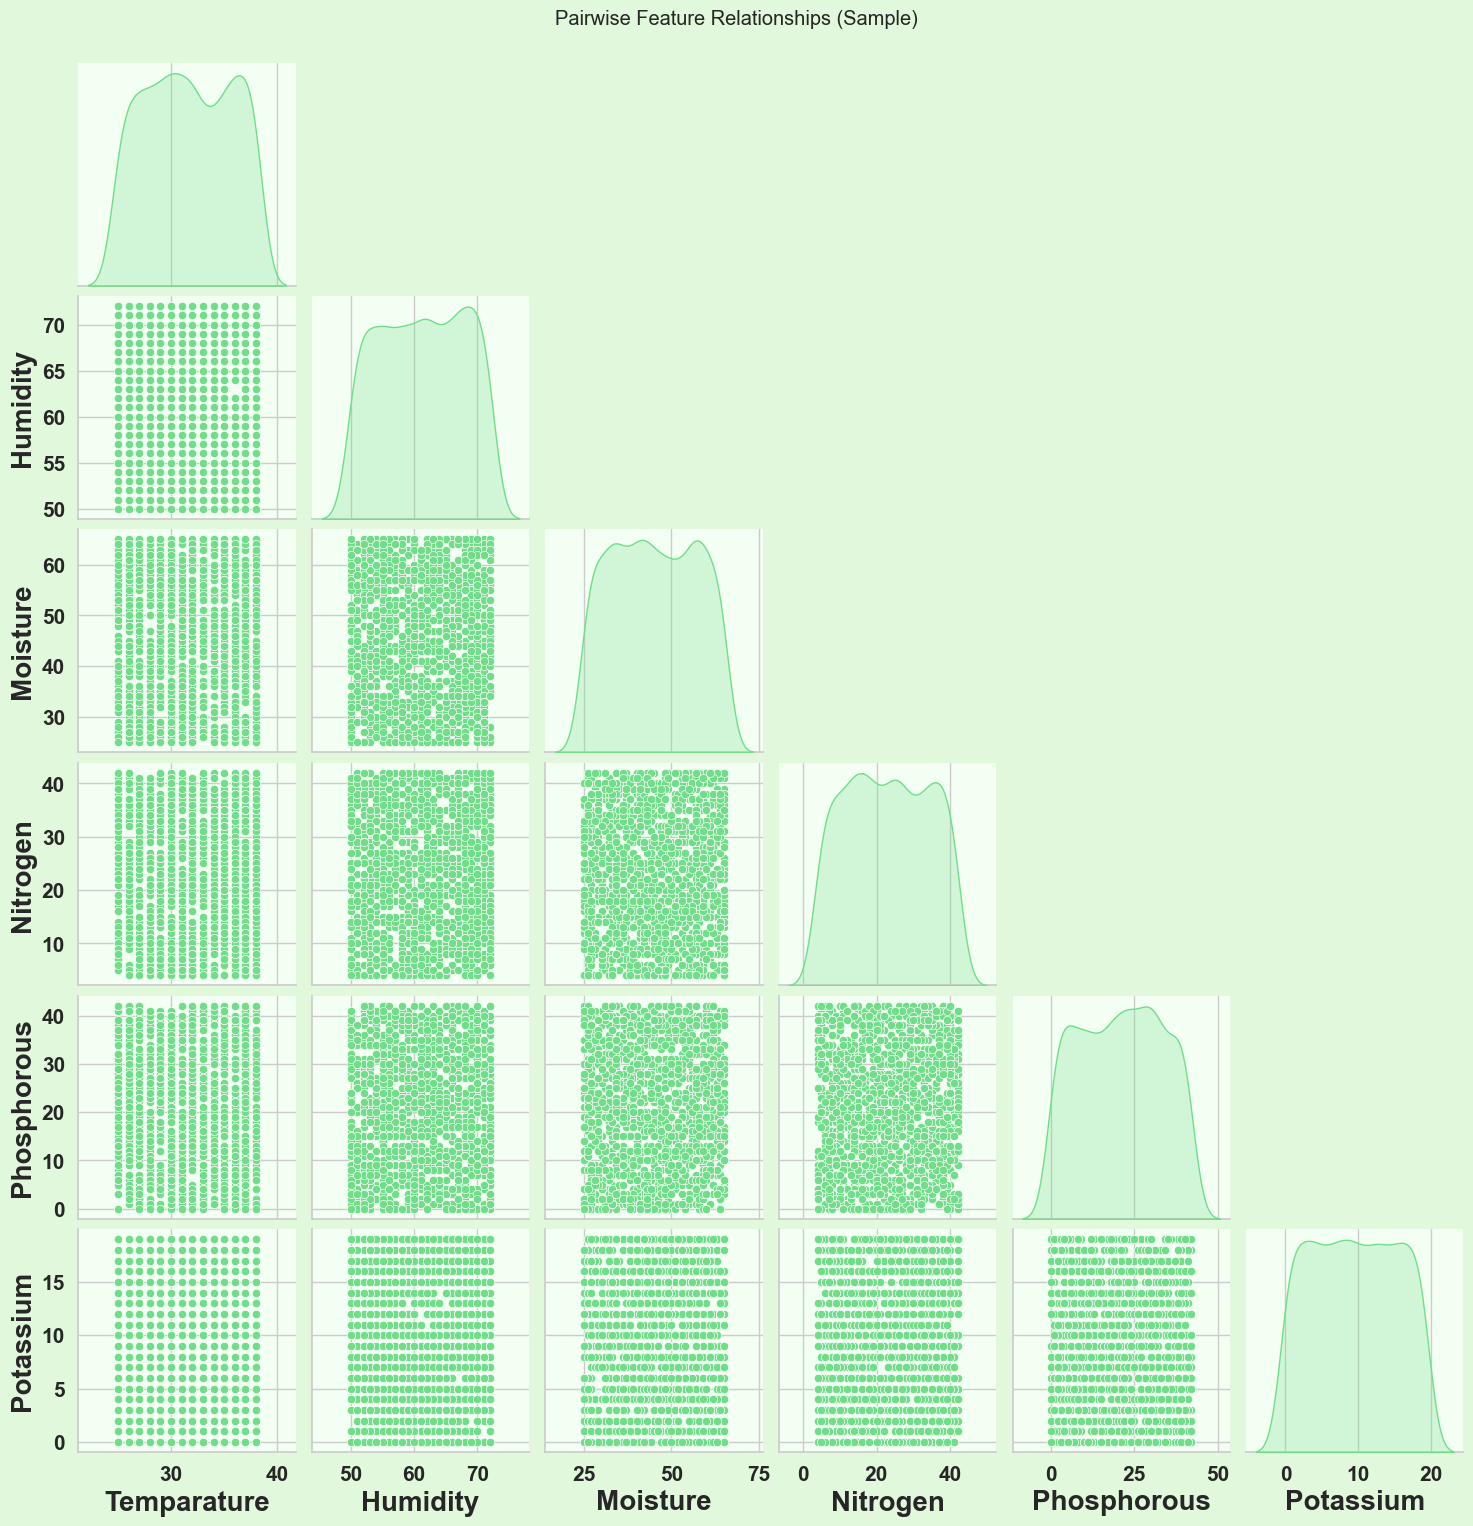

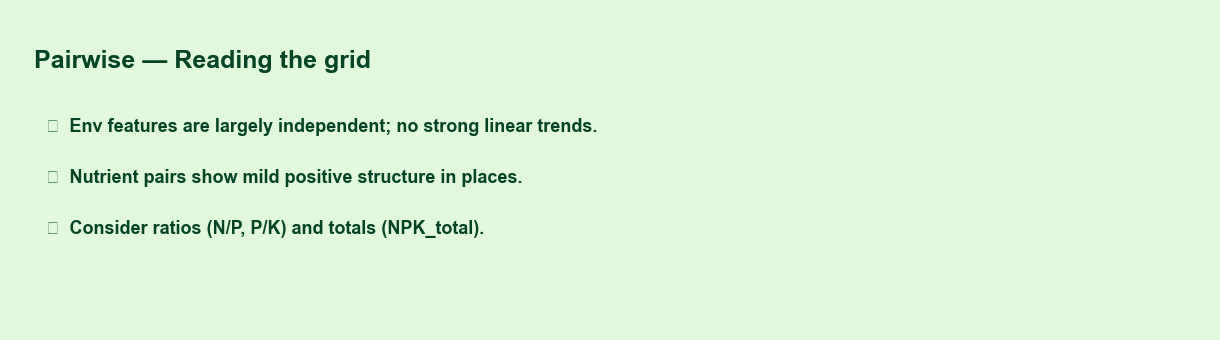

In [14]:
sample = wdf.sample(min(1500, len(wdf)), random_state=42)
cols = ['Temparature','Humidity','Moisture','Nitrogen','Phosphorous','Potassium']
sns.pairplot(sample[cols], corner=True, diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships (Sample)', y=1.02); plt.show()
insight_card("Pairwise — Reading the grid", ["Env features are largely independent; no strong linear trends.", "Nutrient pairs show mild positive structure in places.", "Consider ratios (N/P, P/K) and totals (NPK_total)."])


## 14. Feature Encoding and Preprocessing

In [15]:

# -------------------------------------------------------
# TARGET ENCODING
# -------------------------------------------------------
le = LabelEncoder()
train["Fertilizer_Code"] = le.fit_transform(train["Fertilizer Name"])
y = train["Fertilizer_Code"]

# -------------------------------------------------------
# FEATURES
# -------------------------------------------------------
categorical = ["Soil Type", "Crop Type"]
numerical = ["Temparature", "Humidity", "Moisture",
             "Nitrogen", "Potassium", "Phosphorous"]

# Preprocessing
preprocess = ColumnTransformer([
    ("scale", StandardScaler(), numerical),
    ("onehot", OneHotEncoder(handle_unknown='ignore'), categorical)
])


## 15. Model and hyper param tunning

In [16]:
# -------------------------------------------------------
# MODEL DEFINITIONS
# -------------------------------------------------------

xgb = XGBClassifier(
    tree_method="hist",
    eval_metric="mlogloss",
    use_label_encoder=False
)

lgb = LGBMClassifier(objective="multiclass", num_class=len(le.classes_))

cat = CatBoostClassifier(
    verbose=0,
    loss_function="MultiClass"
)

# -------------------------------------------------------
# PARAM GRIDS
# -------------------------------------------------------

param_xgb = {
    "n_estimators": [200, 300, 1000],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.08],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 1.0]
}

param_lgb = {
    "n_estimators": [300, 600],
    "max_depth": [-1, 6, 10],
    "learning_rate": [0.03, 0.05, 0.1]
}

param_cat = {
    "iterations": [300, 600],
    "depth": [6, 8],
    "learning_rate": [0.03, 0.05]
}

# -------------------------------------------------------
# 5×2 FOLD CV REPEATED
# -------------------------------------------------------
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

# -------------------------------------------------------
# HYPERPARAMETER TUNING
# -------------------------------------------------------

def tune_model(model, params):
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])

    search = RandomizedSearchCV(
        pipe,
        {"model__" + k: v for k, v in params.items()},
        n_iter=10,
        scoring="neg_log_loss",
        cv=cv,
        verbose=1,
        n_jobs=-1
    )

    search.fit(train.drop(columns=["Fertilizer Name", "Fertilizer_Code"]), y)
    return search.best_estimator_

In [ ]:
best_xgb = tune_model(xgb, param_xgb)
best_lgb = tune_model(lgb, param_lgb)
best_cat = tune_model(cat, param_cat)

# -------------------------------------------------------
# WEIGHTED ENSEMBLE PREDICTION
# -------------------------------------------------------
test_X = test.copy()

proba_xgb = best_xgb.predict_proba(test_X)
proba_lgb = best_lgb.predict_proba(test_X)
proba_cat = best_cat.predict_proba(test_X)

# weights can be tuned based on validation performance
ensemble_proba = (
      0.4 * proba_xgb +
      0.25 * proba_lgb +
      0.35 * proba_cat
)



Fitting 10 folds for each of 10 candidates, totalling 100 fits


## Store model for further evaluation

In [ ]:
# Do save models for further development can be tuned based on validation performance

joblib.dump(best_xgb, "models/best_xgb.pkl")
joblib.dump(best_lgb, "models/best_lgb.pkl")
joblib.dump(best_cat, "models/best_cat.pkl")
joblib.dump(le, "models/label_encoder.pkl")

## 16. TOP-3 FERTILIZER PREDICTION

In [ ]:
# -------------------------------------------------------
# TOP-3 FERTILIZER PREDICTION
# -------------------------------------------------------
top3_idx = np.argsort(-ensemble_proba, axis=1)[:, :3]
top3_labels = le.inverse_transform(top3_idx.flatten()).reshape(-1, 3)

test["Fertilizer Name"] = [" ".join(row) for row in top3_labels]

# Final output
submission = test[["id", "Fertilizer Name"]]
print(submission.head())
    
submission.to_csv(PROJECT_HOME+"/output_dir/submission_Approach1.csv", index=False)

       id          Fertilizer Name
0  750000       28-28 DAP 10-26-26
1  750001  17-17-17 20-20 10-26-26
2  750002     20-20 28-28 14-35-14
3  750003    14-35-14 DAP 17-17-17
4  750004  20-20 10-26-26 17-17-17


## Kaggle Score: Mean Average Precision@3 (MAP@3) - 0.34556